2025-02-24 08:55:04.178367: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-24 08:55:04.210690: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-24 08:55:04.210714: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-24 08:55:04.210738: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-24 08:55:04.216459: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-24 08:55:04.216864: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

Found 9957 files belonging to 4 classes.


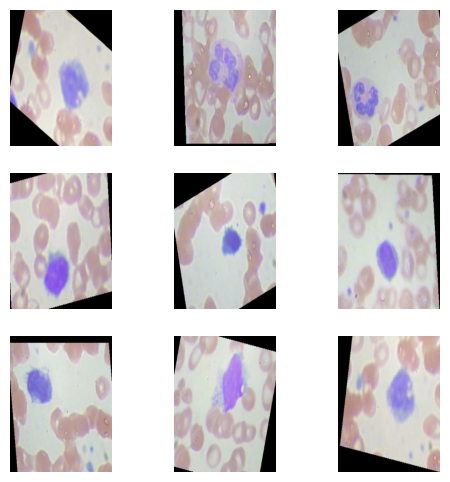

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Parametry
IMG_SIZE = (320, 240)
BATCH_SIZE = 32
DATA_DIR = "images/TRAIN"

# Wczytanie zbioru treningowego
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'  # Bo mamy więcej niż 2 klasy
)

# Podział na trening/validację
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset = train_dataset.take(train_size)
val_dataset = train_dataset.skip(train_size)

# Normalizacja wartości pikseli do [0,1]
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))

# Podgląd danych
plt.figure(figsize=(6,6))
for images, labels in train_dataset.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy())
        plt.axis("off")
    plt.show()


## 🧠 Budowa modelu CNN do klasyfikacji komórek krwi

Teraz stworzymy **konwolucyjny model sieci neuronowej (CNN)**, który nauczy się rozpoznawać typy komórek na podstawie zdjęć.  
Model składa się z kilku warstw:

1. **Warstwy konwolucyjne (`Conv2D`)** – wykrywają wzorce na obrazach, np. kształty komórek.  
2. **Warstwy `MaxPooling2D`** – zmniejszają rozmiar obrazu, aby uprościć obliczenia.  
3. **Warstwa `Flatten`** – przekształca obraz w wektor cech.  
4. **Warstwa gęsta (`Dense`)** – uczy się rozpoznawać kategorie komórek.  
5. **Warstwa wyjściowa (`Dense(4, activation='softmax')`)** – zwraca prawdopodobieństwa dla 4 klas.  

Funkcja aktywacji **ReLU** przyspiesza uczenie, a **Dropout (0.5)** zapobiega przeuczeniu modelu.  


In [3]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(320, 240, 3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),    #128
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')  # 4 klasy
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 318, 238, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 159, 119, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 157, 117, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 78, 58, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 76, 56, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 38, 28, 128)      

## 🚀 Trenowanie modelu na danych komórek krwi

Model zostanie nauczony na zbiorze treningowym przez 20 epok.  
Podczas każdej epoki:
- Model przeanalizuje dane i dostosuje swoje wagi.
- Sprawdzimy jego skuteczność na zbiorze walidacyjnym.

Na koniec zapisujemy wytrenowany model (`.h5`), aby później można było go załadować i użyć do klasyfikacji nowych zdjęć.  


In [4]:
EPOCHS = 20
# train_dataset = train_dataset.repeat()

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    steps_per_epoch=len(train_dataset)
)

# Zapisanie modelu
model.save("blood_cell_classifier.h5")


Epoch 1/20
 12/249 [>.............................] - ETA: 3:53 - loss: 2.2874 - accuracy: 0.2266

KeyboardInterrupt: 